In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Dataset

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


## Scaling

In [4]:
# df.Temp = df.Temp.transform(lambda x: (x - x.mean()) / x.std())

<AxesSubplot: xlabel='Date'>

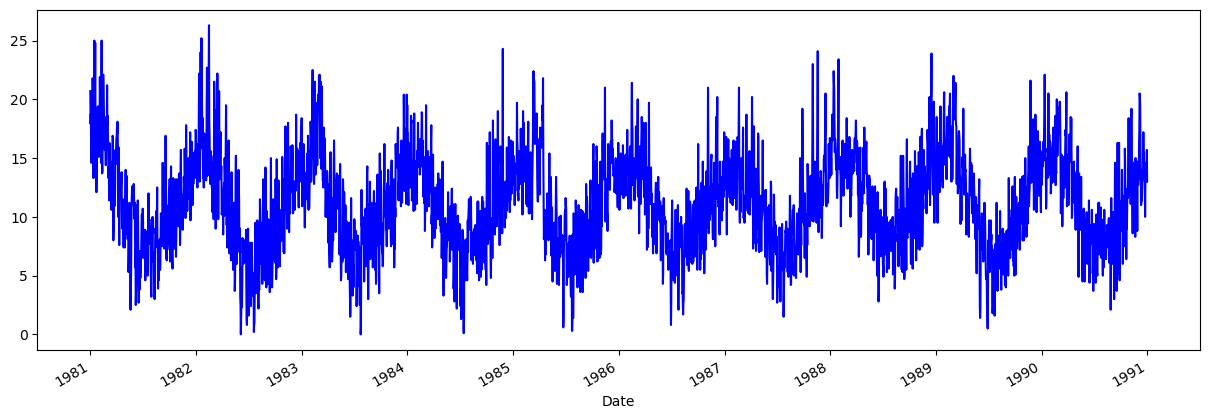

In [5]:
df.Temp.plot(figsize=(15, 5), color="b")

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataset & Dataloader

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [41]:
seq_len = 7
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)  

(N, S, F): (417, 7, 5)
Note: last 0 data excluded

(N, S, F): (104, 7, 5)
Note: last 1 data excluded



# Arsitektur & Config

In [42]:
from jcopdl.layers import linear_block

In [43]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout) :
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [44]:
config = set_config({
    "input_size" : train_set.n_feature, 
    "seq_len" :  train_set.n_seq,    
    "output_size" : 1,
    "hidden_size" : 128,
    "num_layers" : 2,
    "dropout" : 0,
})

# Training Preparation -> MCOC

In [45]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir="model/multivar")

# Training

In [46]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 117.8832 | Test_cost  = 93.0061 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 68.0496 | Test_cost  = 52.8407 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 41.7231 | Test_cost  = 37.3554 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 30.9905 | Test_cost  = 29.3401 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 25.0178 | Test_cost  = 24.3631 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 21.3342 | Test_cost  = 21.1937 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 19.0697 | Test_cost  = 19.2235 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 17.7295 | Test_cost  = 18.0439 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 16.9713 | Test_cost  = 17.3596 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 16.5549 | Test_cost  = 16.9668 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 16.3240 | Test_cost  = 16.7362 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 16.1857 | Test_cost  = 16.5920 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 16.0895 | Test_cost  = 16.4913 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 16.0087 | Test_cost  = 16.4086 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 15.9260 | Test_cost  = 16.3214 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 15.8090 | Test_cost  = 16.1541 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 15.5709 | Test_cost  = 15.8875 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 15.1860 | Test_cost  = 15.3261 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 14.2812 | Test_cost  = 13.9183 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 12.5734 | Test_cost  = 12.0967 | 


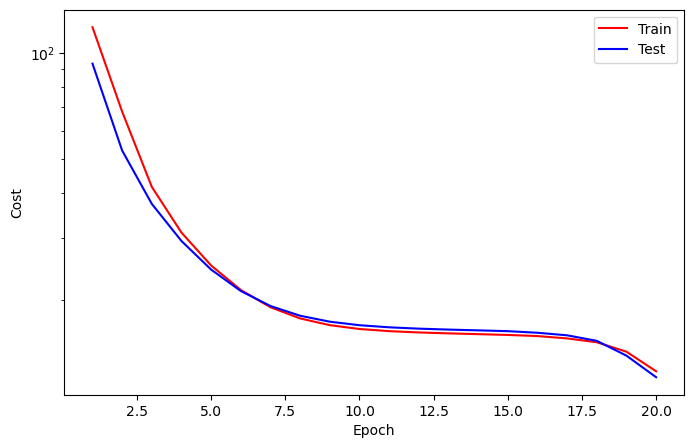

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 11.2081 | Test_cost  = 10.9656 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 10.3323 | Test_cost  = 10.0678 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 9.6384 | Test_cost  = 9.3151 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 9.0563 | Test_cost  = 8.6927 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 8.5874 | Test_cost  = 8.1925 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 8.2149 | Test_cost  = 7.7958 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 7.9245 | Test_cost  = 7.4872 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 7.7051 | Test_cost  = 7.2513 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 7.5385 | Test_cost  = 7.0669 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 7.4063 | Test_cost  = 6.9154 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 7.2966 | Test_cost  = 6.7849 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 7.2027 | Test_cost  = 6.6697 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 7.1203 | Test_cost  = 6.5678 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 7.0466 | Test_cost  = 6.4775 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 6.9801 | Test_cost  = 6.3963 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 6.9203 | Test_cost  = 6.3206 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 6.8664 | Test_cost  = 6.2494 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 6.8174 | Test_cost  = 6.1847 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 6.7732 | Test_cost  = 6.1265 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 6.7329 | Test_cost  = 6.0733 | 


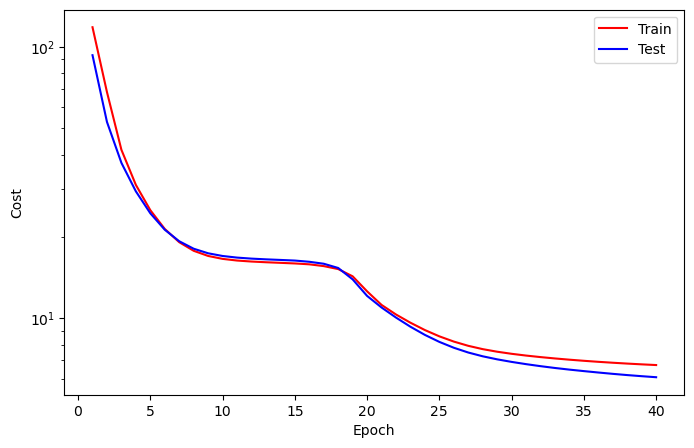

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 6.6960 | Test_cost  = 6.0239 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 6.6621 | Test_cost  = 5.9774 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 6.6308 | Test_cost  = 5.9334 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 6.6018 | Test_cost  = 5.8920 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 6.5749 | Test_cost  = 5.8531 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 6.5495 | Test_cost  = 5.8165 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 6.5254 | Test_cost  = 5.7823 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 6.5026 | Test_cost  = 5.7501 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 6.4808 | Test_cost  = 5.7197 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 6.4600 | Test_cost  = 5.6911 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 6.4403 | Test_cost  = 5.6640 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 6.4215 | Test_cost  = 5.6384 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 6.4036 | Test_cost  = 5.6141 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 6.3865 | Test_cost  = 5.5911 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 6.3703 | Test_cost  = 5.5693 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 6.3548 | Test_cost  = 5.5487 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 6.3400 | Test_cost  = 5.5290 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 6.3259 | Test_cost  = 5.5104 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 6.3125 | Test_cost  = 5.4926 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 6.2997 | Test_cost  = 5.4757 | 


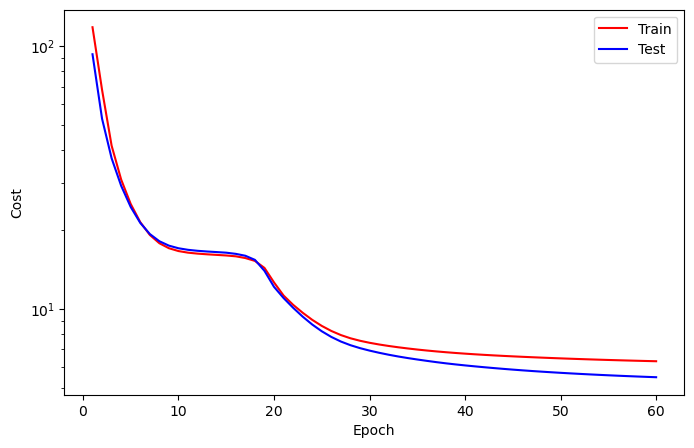

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 6.2875 | Test_cost  = 5.4596 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 6.2758 | Test_cost  = 5.4442 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 6.2646 | Test_cost  = 5.4297 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 6.2540 | Test_cost  = 5.4161 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 6.2437 | Test_cost  = 5.4032 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 6.2339 | Test_cost  = 5.3911 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 6.2244 | Test_cost  = 5.3798 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 6.2153 | Test_cost  = 5.3692 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 6.2065 | Test_cost  = 5.3593 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 6.1980 | Test_cost  = 5.3500 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 6.1898 | Test_cost  = 5.3413 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 6.1818 | Test_cost  = 5.3332 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 6.1741 | Test_cost  = 5.3256 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 6.1667 | Test_cost  = 5.3186 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 6.1594 | Test_cost  = 5.3120 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 6.1522 | Test_cost  = 5.3059 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 6.1453 | Test_cost  = 5.3002 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 6.1384 | Test_cost  = 5.2950 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 6.1317 | Test_cost  = 5.2901 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 6.1250 | Test_cost  = 5.2855 | 


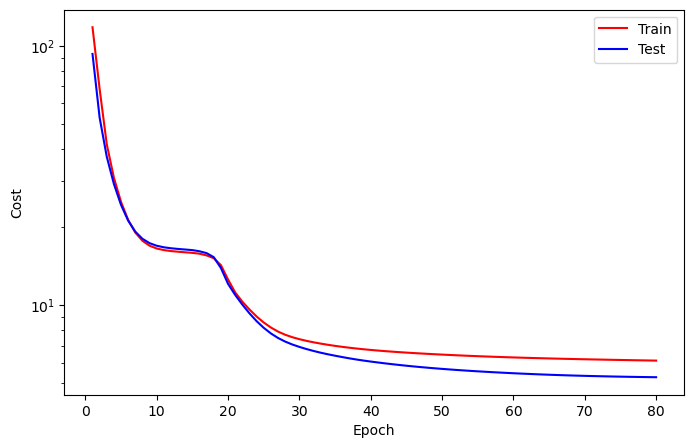

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 6.1185 | Test_cost  = 5.2812 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 6.1121 | Test_cost  = 5.2773 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 6.1057 | Test_cost  = 5.2736 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 6.0994 | Test_cost  = 5.2701 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 6.0932 | Test_cost  = 5.2668 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 6.0872 | Test_cost  = 5.2638 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 6.0812 | Test_cost  = 5.2609 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 6.0754 | Test_cost  = 5.2581 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 6.0696 | Test_cost  = 5.2555 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 6.0641 | Test_cost  = 5.2530 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 6.0586 | Test_cost  = 5.2507 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 6.0533 | Test_cost  = 5.2484 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 6.0481 | Test_cost  = 5.2462 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 6.0430 | Test_cost  = 5.2441 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 6.0380 | Test_cost  = 5.2420 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 6.0331 | Test_cost  = 5.2401 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 6.0283 | Test_cost  = 5.2382 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 6.0236 | Test_cost  = 5.2363 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 6.0190 | Test_cost  = 5.2345 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 6.0145 | Test_cost  = 5.2328 | 


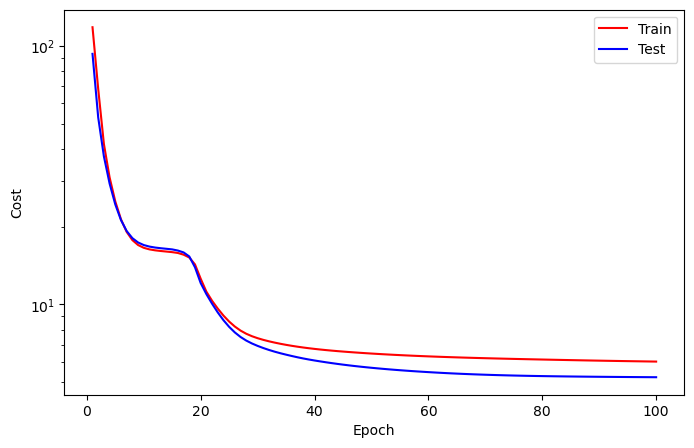

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 6.0100 | Test_cost  = 5.2311 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 6.0055 | Test_cost  = 5.2295 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 6.0012 | Test_cost  = 5.2279 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 5.9968 | Test_cost  = 5.2264 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 5.9926 | Test_cost  = 5.2249 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 5.9883 | Test_cost  = 5.2235 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 5.9842 | Test_cost  = 5.2221 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 5.9800 | Test_cost  = 5.2208 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 5.9759 | Test_cost  = 5.2195 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 5.9719 | Test_cost  = 5.2182 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 5.9679 | Test_cost  = 5.2170 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 5.9639 | Test_cost  = 5.2159 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 5.9600 | Test_cost  = 5.2148 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 5.9561 | Test_cost  = 5.2137 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 5.9522 | Test_cost  = 5.2126 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 5.9483 | Test_cost  = 5.2116 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 5.9445 | Test_cost  = 5.2106 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 5.9406 | Test_cost  = 5.2096 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 5.9368 | Test_cost  = 5.2087 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 5.9330 | Test_cost  = 5.2077 | 


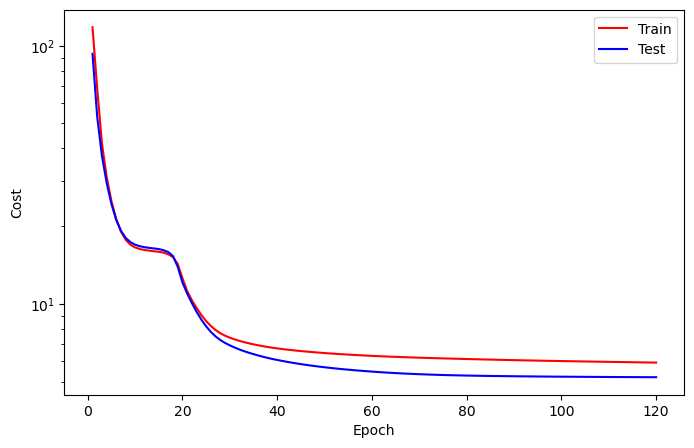

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 5.9292 | Test_cost  = 5.2068 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 5.9254 | Test_cost  = 5.2059 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 5.9216 | Test_cost  = 5.2050 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 5.9178 | Test_cost  = 5.2042 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 5.9140 | Test_cost  = 5.2033 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 5.9102 | Test_cost  = 5.2025 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 5.9064 | Test_cost  = 5.2016 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 5.9026 | Test_cost  = 5.2008 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 5.8988 | Test_cost  = 5.2000 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 5.8950 | Test_cost  = 5.1992 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 5.8912 | Test_cost  = 5.1984 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 5.8873 | Test_cost  = 5.1976 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 5.8835 | Test_cost  = 5.1969 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 5.8796 | Test_cost  = 5.1961 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 5.8757 | Test_cost  = 5.1954 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 5.8718 | Test_cost  = 5.1946 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 5.8679 | Test_cost  = 5.1939 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 5.8639 | Test_cost  = 5.1933 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 5.8599 | Test_cost  = 5.1926 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 5.8559 | Test_cost  = 5.1919 | 


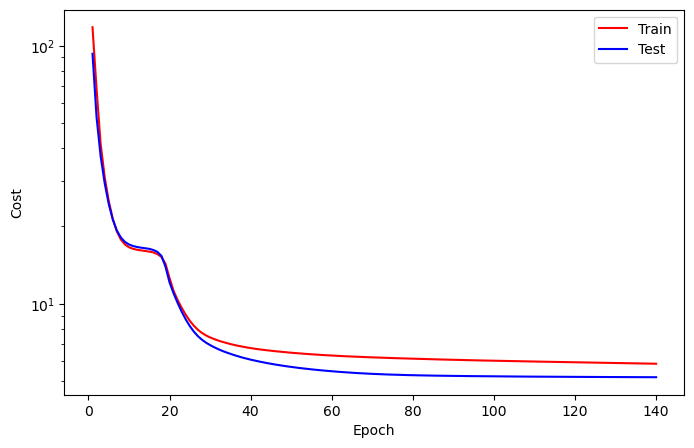

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 5.8519 | Test_cost  = 5.1913 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 5.8478 | Test_cost  = 5.1907 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 5.8437 | Test_cost  = 5.1901 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 5.8395 | Test_cost  = 5.1895 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 5.8353 | Test_cost  = 5.1890 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 5.8311 | Test_cost  = 5.1885 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 5.8268 | Test_cost  = 5.1880 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 5.8225 | Test_cost  = 5.1876 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 5.8181 | Test_cost  = 5.1871 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 5.8137 | Test_cost  = 5.1868 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 5.8092 | Test_cost  = 5.1864 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 5.8047 | Test_cost  = 5.1861 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 5.8002 | Test_cost  = 5.1858 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 5.7956 | Test_cost  = 5.1856 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 5.7910 | Test_cost  = 5.1854 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 5.7863 | Test_cost  = 5.1853 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 5.7816 | Test_cost  = 5.1852 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 5.7768 | Test_cost  = 5.1851 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 5.7720 | Test_cost  = 5.1851 | 


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 5.7671 | Test_cost  = 5.1851 | 


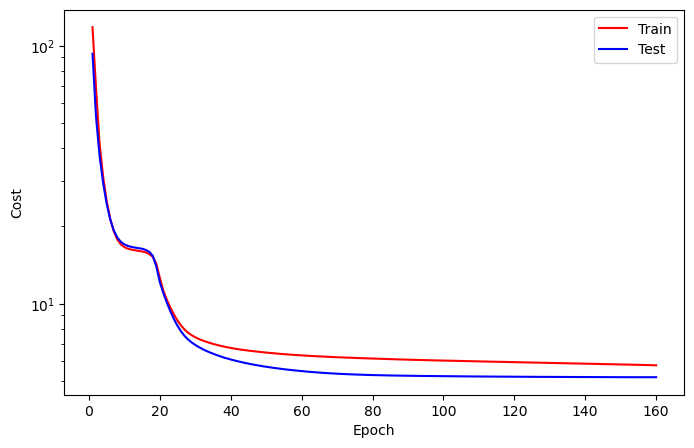

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 5.7622 | Test_cost  = 5.1851 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1851


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 5.7573 | Test_cost  = 5.1852 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1851


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 5.7523 | Test_cost  = 5.1853 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1851


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 5.7472 | Test_cost  = 5.1854 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1851


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 5.7422 | Test_cost  = 5.1856 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1851
==> Execute Early Stopping at epoch: 165 | Best test_cost: 5.1851
==> Best model is saved at model/multivar


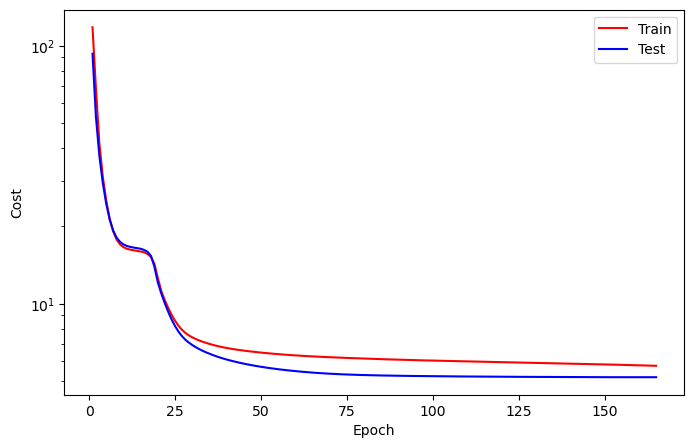

In [47]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
        
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [48]:
from utils import data4pred, pred4pred

In [49]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)  

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

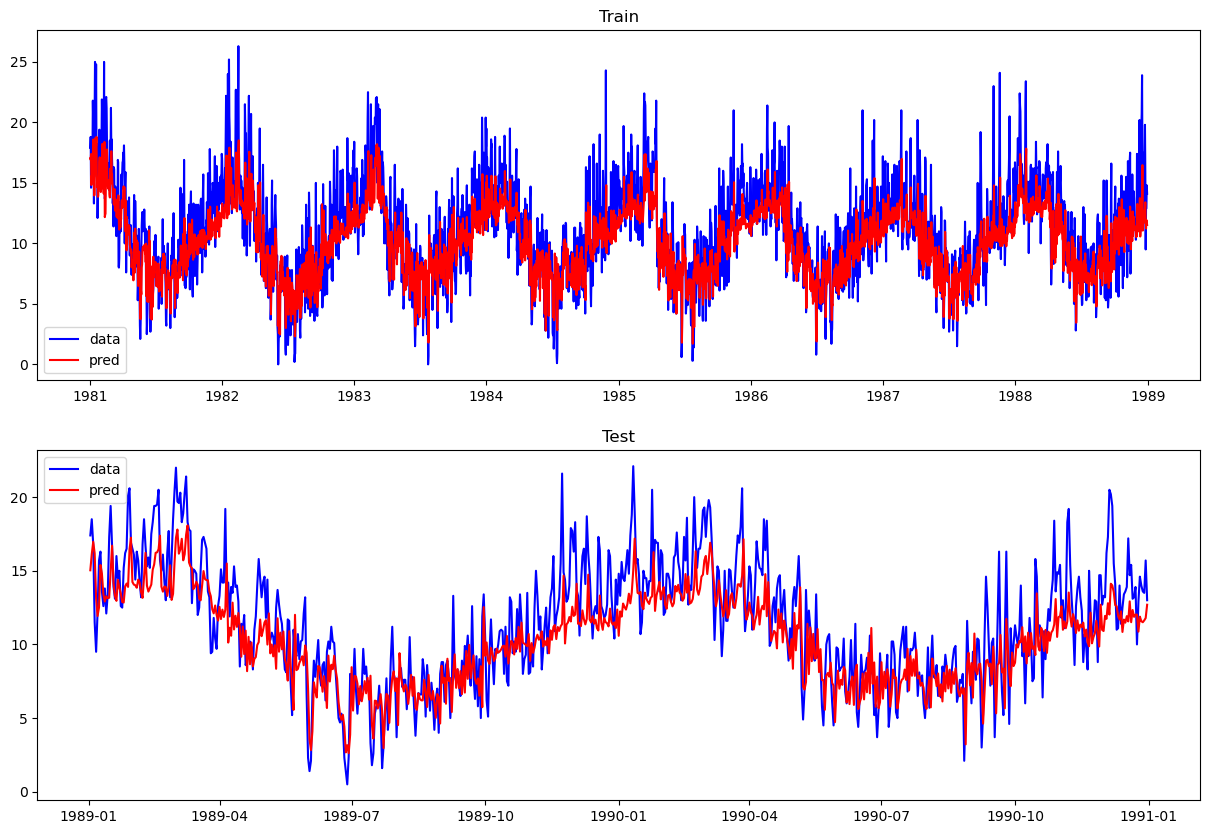

In [50]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

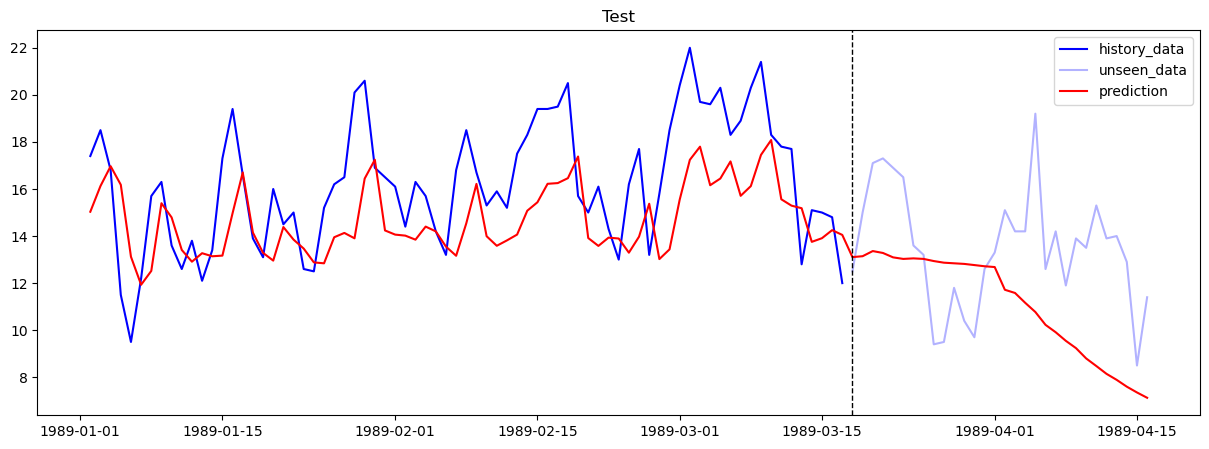

In [51]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");

# More on RNN

In [11]:
from luwiji.rnn import illustration

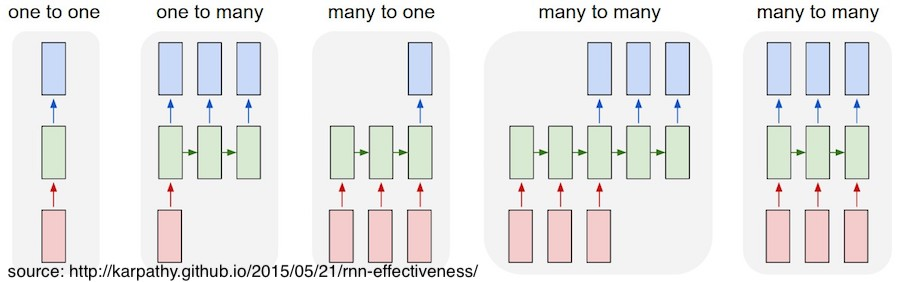

In [12]:
illustration.sequence_model

- One to one (Fixed input and output):
    - Image Classification
- One to many (Fixed input and sequence output):
    - Image Captioning
- Many to one (Sequence input and fixed output):
    - Sentiment analysis
- Many to many (Sequence input and Sequence output):
     - frame level video classification

- Karpathy Github
https://karpathy.github.io/2015/05/21/rnn-effectiveness/

- RNN Midi Composer
https://www.youtube.com/watch?v=0eTYs4n1LKg&t=2s